## Downloading the Dataset

In [1]:
import os
import tarfile as tar
from six.moves import urllib



URL = 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz'
PATH = 'datasets'

def download(url=URL, path=PATH):
    if not os.path.isdir(path):
        os.mkdir(path)
    tar_file_name = os.path.join(path, 'housing.tgz')
    urllib.request.urlretrieve(url, tar_file_name)
    with tar.open(tar_file_name) as fp:
        fp.extractall(path)


download()

## Loading the data into a data frame

In [2]:
import pandas as pd


def load(path=PATH):
    return pd.read_csv(os.path.join(path, 'housing.csv'))


housing = load()

## Exploring the Data Structure

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


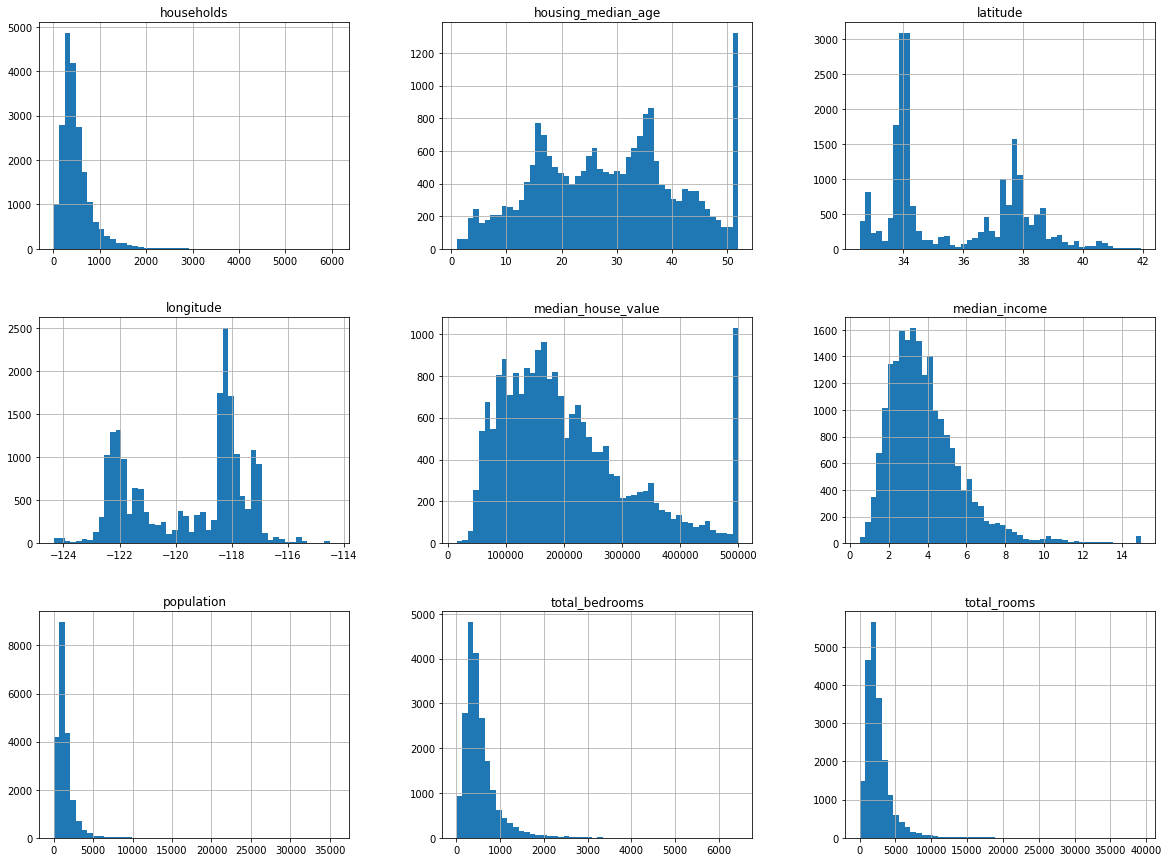

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt


housing.hist(
    bins=50,
    figsize=(20, 15)
)
plt.show()

## Creating a Test Set

Naive approach without any stratification

In [8]:
import numpy as np


def split(data, ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set = int(len(data) * ratio)
    test_indices, train_indices = shuffled_indices[:test_set], shuffled_indices[test_set:]
    return data.iloc[train_indices], data.iloc[test_indices]


train_set, test_set = split(housing, 0.2)
print('Train set : {} Test set : {}'.format(len(train_set), len(test_set)))

Train set : 16512 Test set : 4128


Splitting randomly by using id as unique identifier 

In [9]:
import hashlib as hl


def test_set_check(identifier, ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < (256 * ratio)


def split(data, ratio, id_column, hash=hl.md5):
    ids = data[id_column]
    in_test = ids.apply(lambda id_: test_set_check(id_, ratio, hash))
    return data.loc[~in_test], data.loc[in_test]


housing_with_id = housing.reset_index()
train_set, test_set = split(housing_with_id, 0.2, 'index')
print('Train set : {} Test set : {}'.format(len(train_set), len(test_set)))

Train set : 16362 Test set : 4278


Splitting randomly by using features as unique identifier

In [10]:
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split(housing_with_id, 0.2, "id")
print('Train set : {} Test set : {}'.format(len(train_set), len(test_set)))

Train set : 16267 Test set : 4373


Splitting randomly by using scikit-learn's train_test_split

In [11]:
from sklearn.model_selection import train_test_split


train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print('Train set : {} Test set : {}'.format(len(train_set), len(test_set)))

Train set : 16512 Test set : 4128


In [12]:
from sklearn.model_selection import StratifiedShuffleSplit


housing['income_category'] = np.ceil(housing['median_income'])
housing['income_category'].where(housing['income_category'] < 5, 5.0, inplace=True)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(housing, housing['income_category']):
    stratified_train_set = housing.loc[train_index]
    stratified_test_set = housing.loc[test_index]

print(housing['income_category'].value_counts() / len(housing))

for set_ in (stratified_train_set, stratified_test_set):
    set_.drop('income_category', axis=1, inplace=True)

5.0    0.391812
4.0    0.249516
3.0    0.239632
2.0    0.111337
1.0    0.007703
Name: income_category, dtype: float64


## Visualizing the data 

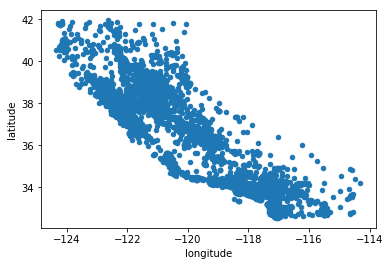

In [13]:
housing = stratified_train_set.copy()

housing.plot(
    kind='scatter',
    x='longitude',
    y='latitude'
)

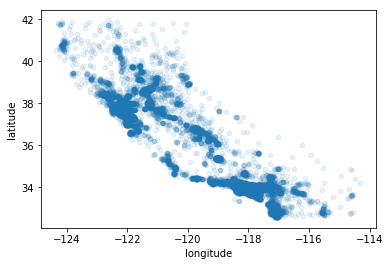

In [14]:
housing.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    alpha=0.1
)

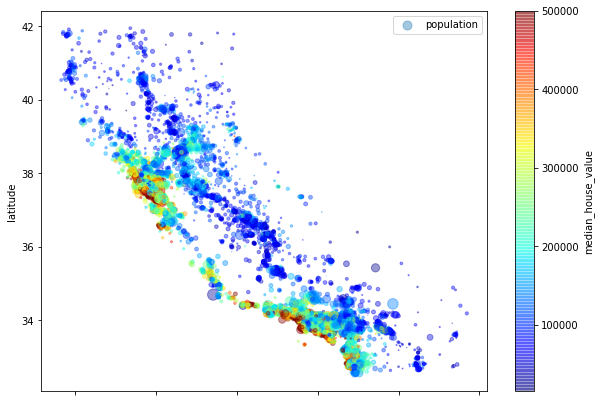

In [15]:
housing.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    alpha=0.4,
    s=housing['population']/100,
    label='population',
    figsize=(10,7),
    c='median_house_value',
    cmap=plt.get_cmap('jet'),
    colorbar=True
)
plt.legend()

## Looking for correlations

Using pandas.DataFrame.corr() method to get correlation matrix

In [16]:
correlation_matrix = housing.corr()
correlation_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690163
total_rooms           0.141468
housing_median_age    0.101851
households            0.071419
total_bedrooms        0.054276
population           -0.020020
longitude            -0.043065
latitude             -0.147961
Name: median_house_value, dtype: float64

Using pandas.plotting.scatter_matrix() method to get correlation matrix plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f4ff518>,
      dtype=object)

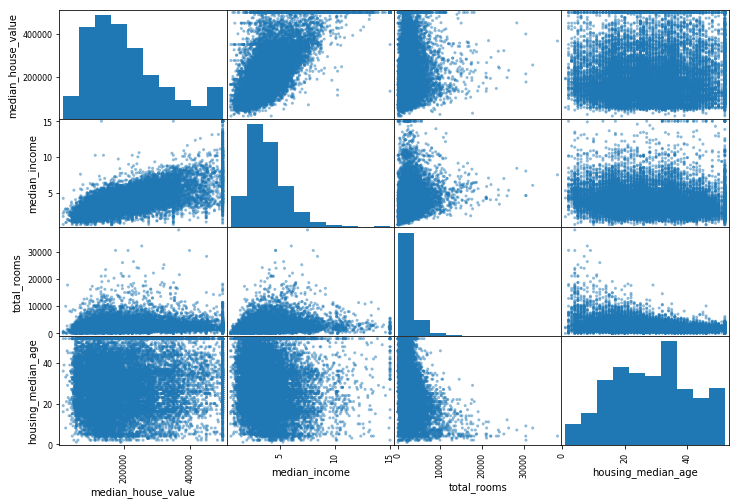

In [17]:
from pandas.plotting import scatter_matrix


attributes = [
    'median_house_value',
    'median_income',
    'total_rooms',
    'housing_median_age'
]
scatter_matrix(housing[attributes], figsize=(12,8))

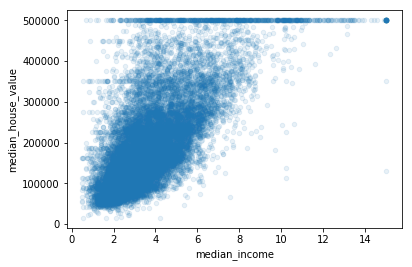

In [18]:
housing.plot(
    kind='scatter',
    x='median_income',
    y='median_house_value',
    alpha=0.1
)

## Expermenting with attribute combinations

In [19]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_rooms'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']


correlation_matrix = housing.corr()
correlation_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.690163
rooms_per_household         0.150634
total_rooms                 0.141468
housing_median_age          0.101851
households                  0.071419
total_bedrooms              0.054276
population                 -0.020020
population_per_household   -0.022300
longitude                  -0.043065
latitude                   -0.147961
bedrooms_per_rooms         -0.257976
Name: median_house_value, dtype: float64

## Preparing the Data 

In [20]:
housing = stratified_train_set.drop('median_house_value', axis=1)
housing_labels = stratified_train_set['median_house_value'].copy()

## Cleaning the data

Getting rid of missing data

In [21]:
housing.dropna(subset=['total_bedrooms'])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17275,-119.69,34.38,39.0,1383.0,459.0,677.0,362.0,2.2500,NEAR OCEAN
6402,-118.02,34.14,34.0,1077.0,257.0,478.0,199.0,2.6316,INLAND
9468,-123.80,39.44,33.0,2024.0,459.0,1019.0,422.0,1.9208,<1H OCEAN
20449,-118.88,34.28,22.0,3369.0,771.0,2751.0,710.0,4.0474,<1H OCEAN
3206,-119.64,36.35,30.0,1765.0,310.0,746.0,298.0,2.8125,INLAND
8859,-118.40,34.07,22.0,2170.0,593.0,850.0,520.0,2.9107,<1H OCEAN
562,-122.23,37.75,50.0,1542.0,289.0,654.0,268.0,3.9632,NEAR BAY
9224,-120.06,36.95,24.0,646.0,134.0,454.0,149.0,2.1250,INLAND
1535,-122.04,37.89,33.0,2423.0,322.0,998.0,346.0,7.5349,NEAR BAY
4659,-118.31,34.05,35.0,1692.0,423.0,1578.0,406.0,2.5313,<1H OCEAN


Getting rid of entire attribute with missing data

In [22]:
housing.drop('total_bedrooms', axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
17275,-119.69,34.38,39.0,1383.0,677.0,362.0,2.2500,NEAR OCEAN
6402,-118.02,34.14,34.0,1077.0,478.0,199.0,2.6316,INLAND
9468,-123.80,39.44,33.0,2024.0,1019.0,422.0,1.9208,<1H OCEAN
20449,-118.88,34.28,22.0,3369.0,2751.0,710.0,4.0474,<1H OCEAN
3206,-119.64,36.35,30.0,1765.0,746.0,298.0,2.8125,INLAND
8859,-118.40,34.07,22.0,2170.0,850.0,520.0,2.9107,<1H OCEAN
562,-122.23,37.75,50.0,1542.0,654.0,268.0,3.9632,NEAR BAY
9224,-120.06,36.95,24.0,646.0,454.0,149.0,2.1250,INLAND
1535,-122.04,37.89,33.0,2423.0,998.0,346.0,7.5349,NEAR BAY
4659,-118.31,34.05,35.0,1692.0,1578.0,406.0,2.5313,<1H OCEAN


Naively setting the missing data to some value(zero, mean, median etc)

In [23]:
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)

Using sklearn.preprocessing.Imputer to take care of missing values

In [24]:
from sklearn.preprocessing import Imputer


imputer = Imputer(strategy='median')
housing_numerical = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_numerical)
# imputer.statistics_
X = imputer.transform(housing_numerical)
housing_train = pd.DataFrame(X, columns=housing_numerical.columns)

## Handling Text and Categorical attributes 

Using sklearn.preprocessing.LabelEncoder for encoding categorical data

In [25]:
from sklearn.preprocessing import LabelEncoder


encoder = LabelEncoder()
housing_categorical = housing['ocean_proximity']


housing_categorical_encoded = encoder.fit_transform(housing_categorical)
housing_categorical_encoded

array([4, 1, 0, ..., 3, 0, 3])

Using sklearn.preprocessing.OneHotEncoder for encoding categorical data

In [26]:
from sklearn.preprocessing import OneHotEncoder


encoder = OneHotEncoder()
housing_categorical_one_hot = encoder.fit_transform(housing_categorical_encoded.reshape(-1, 1))
housing_categorical_one_hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Using sklearn.preprocessing.LabelBinarizer for encoding categorical data and numerical data in 1 go

In [27]:
from sklearn.preprocessing import LabelBinarizer


encoder = LabelBinarizer()
housing_categorical_one_hot = encoder.fit_transform(housing_categorical)
housing_categorical_one_hot

array([[0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

Using Custom Transformers

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin


rooms_index, bedrooms_index, population_index, household_index = 3, 4, 5, 6


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household =  X[:, rooms_index] / X[:, household_index]
        population_per_household = X[:, population_index] / X[:, household_index]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_index] / X[:, rooms_index]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


attributes_adder = CombinedAttributesAdder(False)
housing_with_extra_attributes = attributes_adder.transform(housing.values)

## Feature scaling 

## Transformation Pipelines 

Using sklearn.pipeline.Pipeline

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


numerical_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])
housing_numerical_train = numerical_pipeline.fit_transform(housing_numerical)

Using Custom Pipeline for dealing with numerical and categorical attributes

In [30]:
from sklearn.pipeline import Pipeline


class DataFrameSelector(BaseEstimator, TransformerMixin):

    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values


numerical_attributes, categorical_attributes = list(housing_numerical), ['ocean_proximity']
numerical_pipeline = Pipeline([
    ('selector', DataFrameSelector(numerical_attributes)),
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('selector', DataFrameSelector(categorical_attributes)),
    ('label_binarizer', LabelBinarizer())
])

Joining Custom pipelines using sklearn.pipeline.FeatureUnion

In [31]:
from sklearn.pipeline import FeatureUnion


full_pipeline = FeatureUnion(
    transformer_list=[
        ('num_pipeline', numerical_pipeline),
        ('cat_pipeline', categorical_pipeline),
    ]
)
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared
# housing_prepared.shape

array([[-0.04949427, -0.59541988,  0.82270508, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.78244611, -0.70736928,  0.42527883, ...,  0.        ,
         0.        ,  0.        ],
       [-2.09696432,  1.76484652,  0.34579358, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.33476744,  1.05116913,  1.45858709, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.62801406, -0.72602751,  1.29961659, ...,  0.        ,
         0.        ,  0.        ],
       [-1.32978576,  1.00918811,  0.90219033, ...,  0.        ,
         1.        ,  0.        ]])

## Training  the data

Using Linear Regression model

In [32]:
from sklearn.linear_model import LinearRegression


linear_model = LinearRegression()
linear_model.fit(housing_prepared, housing_labels)

temp_data, temp_label = housing.iloc[:5], housing_labels.iloc[:5]
temp_prepared = full_pipeline.transform(temp_data)
print('Prediction: {}'.format(linear_model.predict(temp_prepared)))
print('Labels: {}'.format(list(temp_label)))

Prediction: [238368. 139648. 170080. 203552. 120096.]
Labels: [281300.0, 252800.0, 93600.0, 182100.0, 70200.0]


/Users/maypatha/Environments/ML/lib/python3.6/site-packages/sklearn/linear_model/base.py:539: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


Measuring RMSE for the model using sklearn.metrics.mean_squared_error

In [33]:
from sklearn.metrics import mean_squared_error


housing_predictions = linear_model.predict(housing_prepared)
linear_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
linear_rmse

67737.64048746403

Using DecisionTrees

In [34]:
from sklearn.tree import DecisionTreeRegressor


tree_model = DecisionTreeRegressor()
tree_model.fit(housing_prepared, housing_labels)

housing_predictions = tree_model.predict(housing_prepared)
tree_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
tree_rmse

0.0

Using Cross validation

In [35]:
from sklearn.model_selection import cross_val_score


def display(scores):
    print('Scores: {}'.format(scores))
    print('Mean: {}'.format(scores.mean()))
    print('Standard Deviation: {}'.format(scores.std()))


linear_scores = cross_val_score(
    linear_model,
    housing_prepared,
    housing_labels,
    scoring='neg_mean_squared_error',
    cv=10
)
tree_scores = cross_val_score(
    tree_model,
    housing_prepared,
    housing_labels,
    scoring='neg_mean_squared_error',
    cv=10
)
linear_model_score = np.sqrt(-linear_scores)
tree_model_score = np.sqrt(-tree_scores)
display(linear_model_score)
display(tree_model_score)

Scores: [66270.28555464 64993.69957771 69195.83957292 65740.09413022
 69482.54999625 67125.44313192 67658.13083291 69342.10407971
 71141.24539566 68776.39268593]
Mean: 67972.57849578743
Standard Deviation: 1841.482339330345
Scores: [72470.74635105 66467.7838486  70917.17823737 67284.81260335
 71551.6098669  66977.80898976 69668.54763392 69991.93583247
 74141.00966187 66736.96870859]
Mean: 69620.8401733885
Standard Deviation: 2545.6505427874613


Using RandomForestRegressor

In [36]:
from sklearn.ensemble import RandomForestRegressor


forest_model = RandomForestRegressor()
forest_model.fit(housing_prepared, housing_labels)
housing_predictions = forest_model.predict(housing_prepared)
forest_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
forest_scores = cross_val_score(
    forest_model,
    housing_prepared,
    housing_labels,
    scoring='neg_mean_squared_error',
    cv=10
)
forest_model_score = np.sqrt(-forest_scores)
display(forest_model_score)

Scores: [50957.18240478 52187.49742897 54033.93198144 50733.47272132
 53438.04609514 51823.5703322  50395.73656824 50747.05287382
 55050.97426619 53624.16425574]
Mean: 52299.16289278241
Standard Deviation: 1554.271703172248


## Fine Tuning the model

Using Grid Search to find best values of hyperparameters

In [40]:
from sklearn.model_selection import GridSearchCV


param_grid = [
    {
        'n_estimators': [3, 10, 30],
        'max_features': [2, 4, 6, 8]
    },
    {
        'bootstrap': [False],
        'n_estimators': [3, 10],
        'max_features': [2, 3, 4]
    }
]
forest_model = RandomForestRegressor()
grid_search = GridSearchCV(
    forest_model,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error'
)
grid_search.fit(housing_prepared, housing_labels)
# grid_search.best_params_
# print(grid_search.best_estimator_)
result = grid_search.cv_results_
for mean_scores, params in zip(result['mean_test_score'], result['params']):
    print(np.sqrt(-mean_scores), params)

63682.33426305116 {'max_features': 2, 'n_estimators': 3}
55011.93244288709 {'max_features': 2, 'n_estimators': 10}
52799.12340782342 {'max_features': 2, 'n_estimators': 30}
60151.73572968676 {'max_features': 4, 'n_estimators': 3}
52170.78424897799 {'max_features': 4, 'n_estimators': 10}
50031.746123209385 {'max_features': 4, 'n_estimators': 30}
58713.94102589044 {'max_features': 6, 'n_estimators': 3}
51778.279405832225 {'max_features': 6, 'n_estimators': 10}
49728.59565932264 {'max_features': 6, 'n_estimators': 30}
58736.57621646141 {'max_features': 8, 'n_estimators': 3}
51927.70602570779 {'max_features': 8, 'n_estimators': 10}
49670.77751234162 {'max_features': 8, 'n_estimators': 30}
62067.40493399044 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54111.204422532624 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59747.511585792745 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52306.65104567156 {'bootstrap': False, 'max_features': 3, 'n_estimators'

## Analysing models abd their errors 

In [42]:
feature_importances = grid_search.best_estimator_.feature_importances_
# feature_importances
extra_attributes = ['rooms_per_household', 'population_per_household', 'bedrooms_per_room']
categorical_one_hot_attributes = list(encoder.classes_)
attributes = numerical_attributes + extra_attributes + categorical_one_hot_attributes
sorted(zip(feature_importances, attributes), reverse=True)

[(0.38605738780715954, 'median_income'),
 (0.15389650186157755, 'INLAND'),
 (0.1107061539460268, 'population_per_household'),
 (0.0691296571475897, 'longitude'),
 (0.06728794823954941, 'latitude'),
 (0.06102503505529392, 'bedrooms_per_room'),
 (0.04282383143212133, 'housing_median_age'),
 (0.03940395776957494, 'rooms_per_household'),
 (0.01552173052645361, 'total_rooms'),
 (0.01488114686771507, 'households'),
 (0.014539632144868793, 'population'),
 (0.014103853323485023, 'total_bedrooms'),
 (0.005357057908526374, '<1H OCEAN'),
 (0.003497118940382352, 'NEAR OCEAN'),
 (0.001507478902706747, 'NEAR BAY'),
 (0.0002615081269687608, 'ISLAND')]

## Evaluate the model on test set 

In [43]:
final_model = grid_search.best_estimator_
X_test, y_test = stratified_test_set.drop('median_house_value', axis=1), stratified_test_set['median_house_value'].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
final_rmse

48697.518264992555